In [2]:
from __future__ import division
import sys, os
import numpy as np
import pandas as pd
from collections import OrderedDict
import pyfits

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.mlab as mlab
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Ellipse

In [83]:
modname      = 'sbpl+blackb'
version      = '-01-'
detector     = 'GBMwLAT'

#version      = 'GBMwLAT_-01-'
#version      = 'GBM_-01-'

burst       = 'bn080916009'

data_dir     = "/Users/derek/Documents/KimiZ/GRBs2/analysis/LAT/%s/integrated/"%burst
mod_dir      = "/Users/derek/Documents/KimiZ/GRBs2/analysis/LAT/%s/PYXSPEC/%s/%s/"%(burst, detector, modname)
desk_dir     = "/Users/derek/Desktop/kim/"
#mod_dir         = "/Users/KimiZ/GRBs2/analysis/LAT/%s/PYXSPEC/%s/%s/"%(burst, detector, modname)
#data_dir        = "/Users/KimiZ/GRBs2/analysis/LAT/%s/integrated/"%burst

fitdatafile       = os.path.join(mod_dir, "xspec_fitresults_%s_%s.fit"%(modname, version))
fakeitdatafile    = os.path.join(data_dir, "fakeit_fitresults_%s_%s.fit"%(modname, version))

outfilename = "AfterFakeit_ParamDistPlots_%s_%s.pdf"%(modname, version)
outfile1 = os.path.join(mod_dir, outfilename)
outfile2 = os.path.join(desk_dir, outfilename)

paramoutfile1 = os.path.join(mod_dir, "AfterFakeit_ParamErrors_%s_%s.txt"%(modname, version))
paramoutfile2 = os.path.join(mod_dir, "AfterFakeit_ParamErrorsEASYREAD_%s_%s.txt"%(modname, version))

In [84]:
f2 = pyfits.open(fakeitdatafile )

iter = 0
fakeparams = pd.DataFrame()
for name in f2[1].data.columns.names:
    fakeparams["%s"%name] = f2[1].data["%s"%name]
    if 'PARAM' in name:
        iter += 1
    else:
        pass
nPars = iter

FakeParams = fakeparams.astype('float64')

In [85]:
f1 = pyfits.open(fitdatafile)
param_dict = OrderedDict()
for name in f1[2].data.columns.names:
    param_dict["%s"%name] = f1[2].data["%s"%name][0]

In [86]:
def check_aic_bic(Cstat, Npars, Ndata=None):
    import numpy as np
    Aic = Cstat + 2.*Npars
    Bic = Cstat + Npars * np.log(Ndata)
    return Aic, Bic

In [87]:
aic = param_dict.get("AIC")
bic = param_dict.get("BIC")
cstat = param_dict.get("CSTAT")
ndata = param_dict.get("NDATA")
covarmat = param_dict.get("COVARMAT")
# nPars # found earlier

In [88]:
if len(covarmat) != nPars**2:
    print "***"*20
    print "*** WARNING: old covarmat.  Has %i elements instead of %i."%(len(covarmat), nPars**2)
    print "***"*20

************************************************************
*** WARNING: old covarmat.  Has 21 elements instead of 36.
************************************************************


In [89]:
AIC, BIC = check_aic_bic(cstat, nPars, ndata)

if AIC != aic:
    raise Warning, "AIC's don't match"
    #raise Exception, "AIC's don't match"

if BIC != bic:
    raise Warning, "BIC's don't match"
    #raise Exception, "BIC's don't match"

In [ ]:
def Plot_ParamComparison(modelname, ax, one, two):

    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    
    XLabel = 'PARAM%i'%(one)
    YLabel = 'PARAM%i'%(two)

    x = FakeParams["%s"%XLabel]
    y = FakeParams["%s"%YLabel]
    muX, sigmaX = np.mean(x), np.sqrt(np.var(x))
    muY, sigmaY = np.mean(y), np.sqrt(np.var(y))

    cov = np.cov(x, y)

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    
    for j in xrange(1, 4):
        width = 2 * j * np.sqrt(vals)[0]
        height = 2 * j * np.sqrt(vals)[1]
        ell = Ellipse(xy=(np.mean(x), np.mean(y)),
                      width= width, height= height,
                      angle= theta)
        ell.set_facecolor('none')
        ax.add_artist(ell)

    plt.errorbar(np.mean(x), np.mean(y), xerr= 3*sigmaX, yerr= 3*sigmaY, color='green', lw=2)
    plt.errorbar(np.mean(x), np.mean(y), xerr= 2*sigmaX, yerr= 2*sigmaY, color='blue', lw=2)
    plt.errorbar(np.mean(x), np.mean(y), xerr= sigmaX, yerr= sigmaY, color='red', lw=2)
    plt.hexbin(x, y, bins='log', gridsize=40, cmap=plt.cm.Greys)#, alpha = 0.1)
    plt.xlim(x.min(), x.max())
    plt.ylim(y.min(), y.max())
    plt.xlabel("%s"%XLabel)
    plt.ylabel("%s"%YLabel)
    plt.title("%s"%modelname)


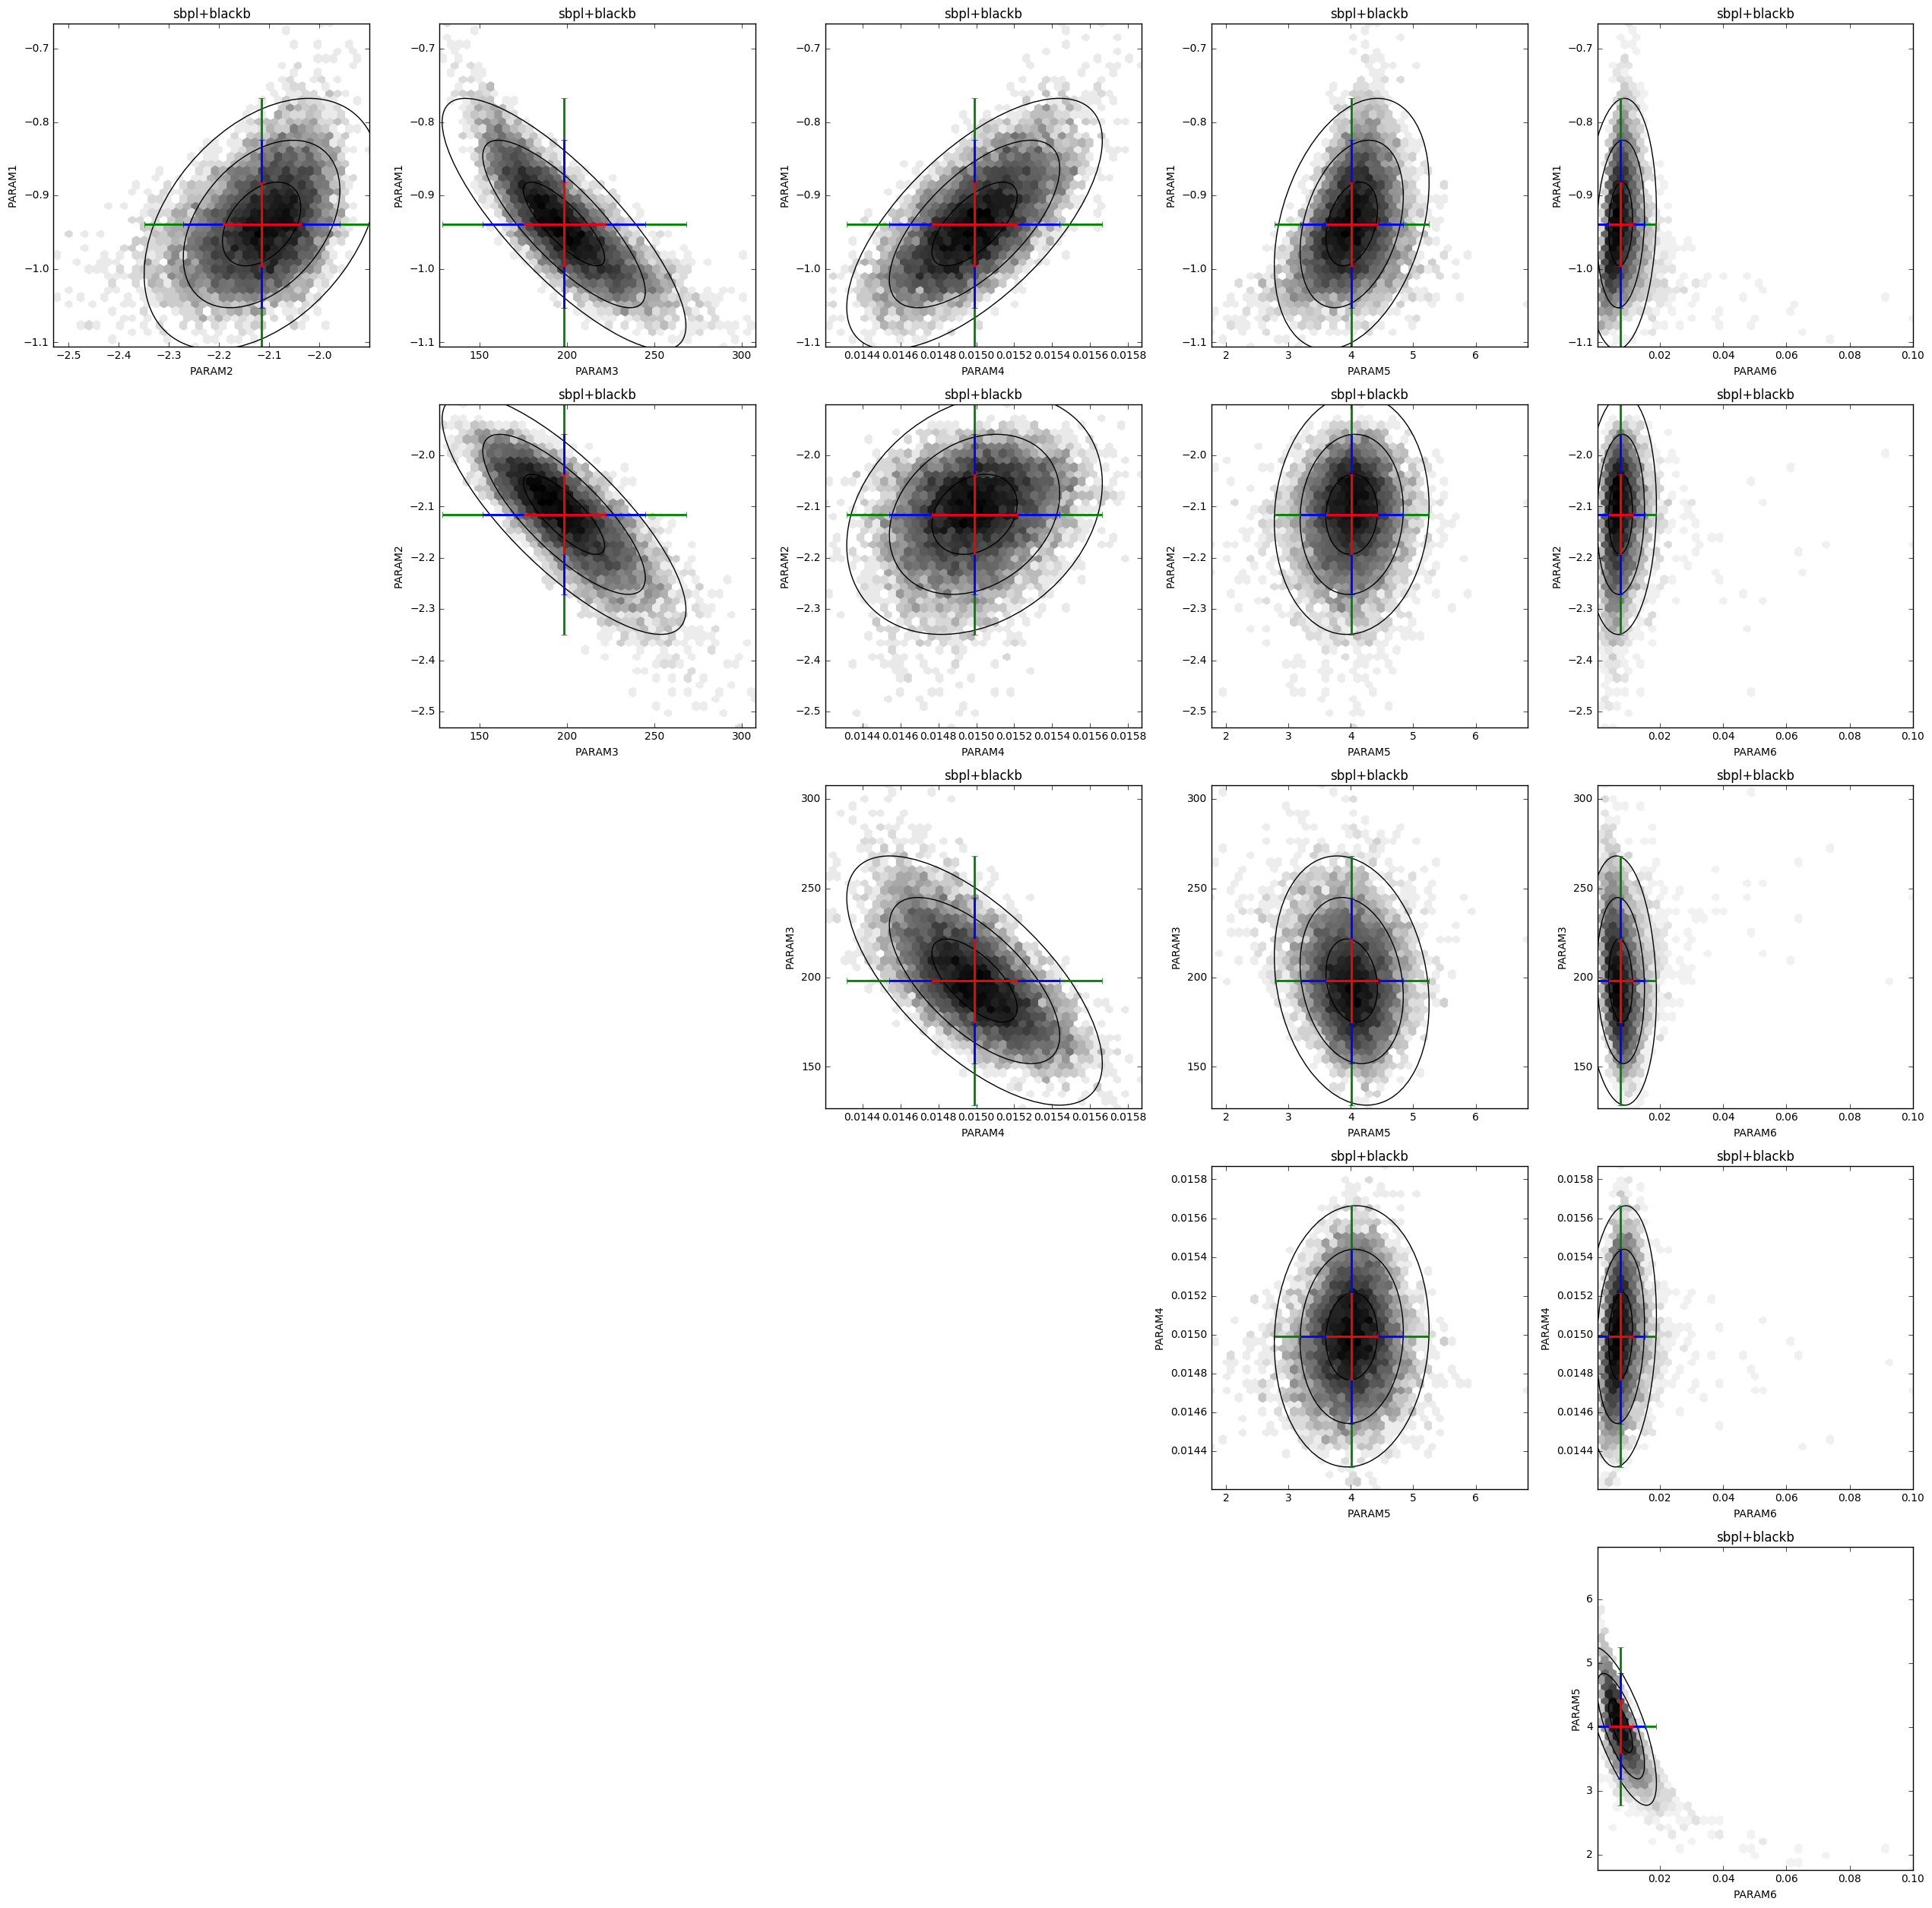

In [10]:
plt.figure(figsize=(5*nPars, 5*nPars))
for i in range(nPars):
    for j in range(i):
        ax = plt.subplot(nPars, nPars, nPars * (j + 1) + i + 1)
        Plot_ParamComparison(modname, ax, i+1, j+1)

plt.tight_layout()
plt.savefig(pp, format='pdf', dpi=150, bbox_inches = 'tight')


In [11]:
def Plot_ParamDistributions(modelname, parameter, Xlimits=None, bins=50):
    XLabel = str(parameter)

    x = FakeParams["%s"%XLabel]
    mu, sigma = np.mean(x), np.sqrt(np.var(x))
    
    fig = plt.figure(figsize = (11,7))
    ax = fig.add_subplot(111)

    n, bins, patches = ax.hist(x, bins, normed=1, facecolor='green', alpha=0.75)
    bincenters = 0.5*(bins[1:]+bins[:-1])

    # add a 'best fit' line for the normal PDF
    y = mlab.normpdf(bincenters, mu, sigma)


    x1siglo = mu-sigma
    x1sighi = mu+sigma
    x2siglo = mu-2*sigma
    x2sighi = mu+2*sigma
    x3siglo = mu-3*sigma
    x3sighi = mu+3*sigma

    # ax.get_xlim()
    ylow, yhi = ax.get_ylim()
    ylabelpos = yhi - (yhi*.01)
    yhigh = yhi + (yhi*.1)
    #ylow, yhigh = ax.yaxis.get_data_interval()
    ax.vlines(mu, ylow, yhigh, linestyle='--', color="black") # mu + sigma
    ax.vlines(mu+sigma, ylow, yhigh, linestyle='--', color="black") # mu + sigma
    ax.vlines(mu-sigma, ylow, yhigh, linestyle='--', color="black") # mu - sigma
    ax.vlines(mu+2*sigma, ylow, yhigh, linestyle='--', color="black") # mu + 2*sigma
    ax.vlines(mu-2*sigma, ylow, yhigh, linestyle='--', color="black") # mu - 2*sigma
    ax.vlines(mu+3*sigma, ylow, yhigh, linestyle='--', color="black") # mu + 3*sigma
    ax.vlines(mu-3*sigma, ylow, yhigh, linestyle='--', color="black") # mu - 3*sigma
    #ax.text(x,y, "text")
    ax.text(mu, ylabelpos, r"$\mu$", fontsize = 12, horizontalalignment='center')
    ax.text(x1sighi, ylabelpos, r"$1\sigma$", fontsize = 12, horizontalalignment='center')
    ax.text(x1siglo, ylabelpos, r"$1\sigma$", fontsize = 12, horizontalalignment='center')
    ax.text(x2sighi, ylabelpos, r"$2\sigma$", fontsize = 12, horizontalalignment='center')
    ax.text(x2siglo, ylabelpos, r"$2\sigma$", fontsize = 12, horizontalalignment='center')
    ax.text(x3sighi, ylabelpos, r"$3\sigma$", fontsize = 12, horizontalalignment='center')
    ax.text(x3siglo, ylabelpos, r"$3\sigma$", fontsize = 12, horizontalalignment='center')
    ax.set_ylim(ylow, yhigh)
    
    ax.set_xlim(mu-5*sigma, mu+5*sigma)
    
    # if Xlimits is not None:
    #     ax.set_xlim(Xlimits)
    
    ax.plot(bincenters, y, 'r--', linewidth=1)
    ax.set_xlabel('%s'%XLabel)
    ax.set_title('%s'%modelname)


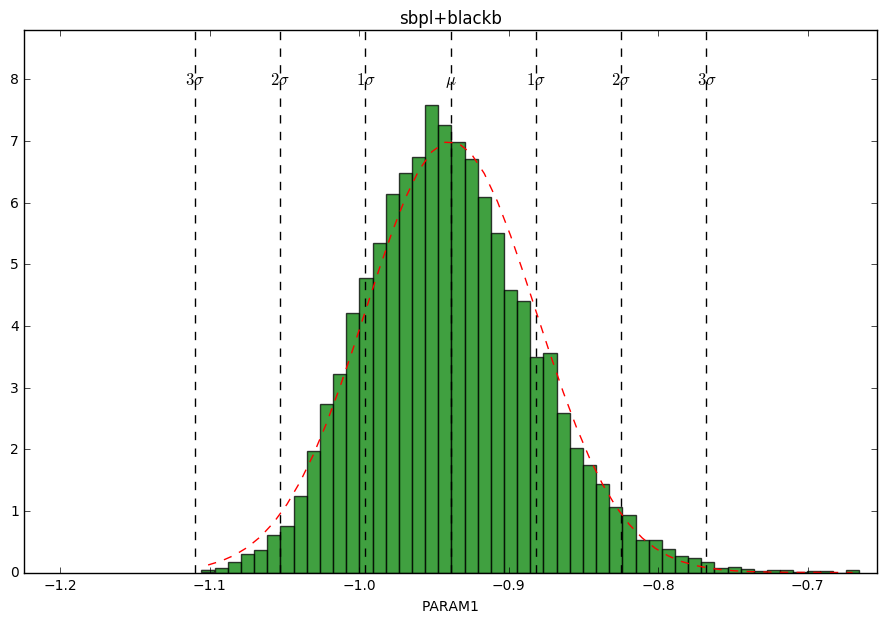

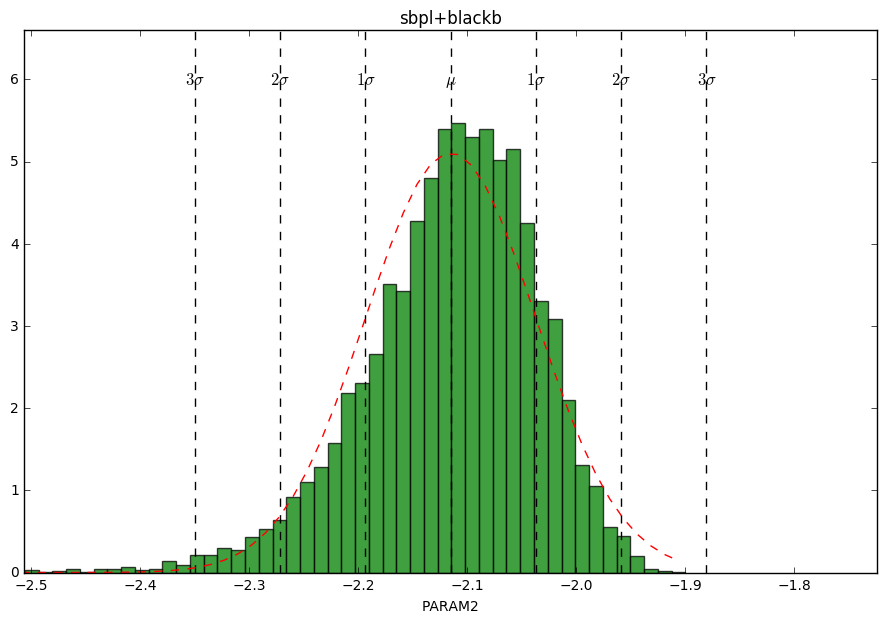

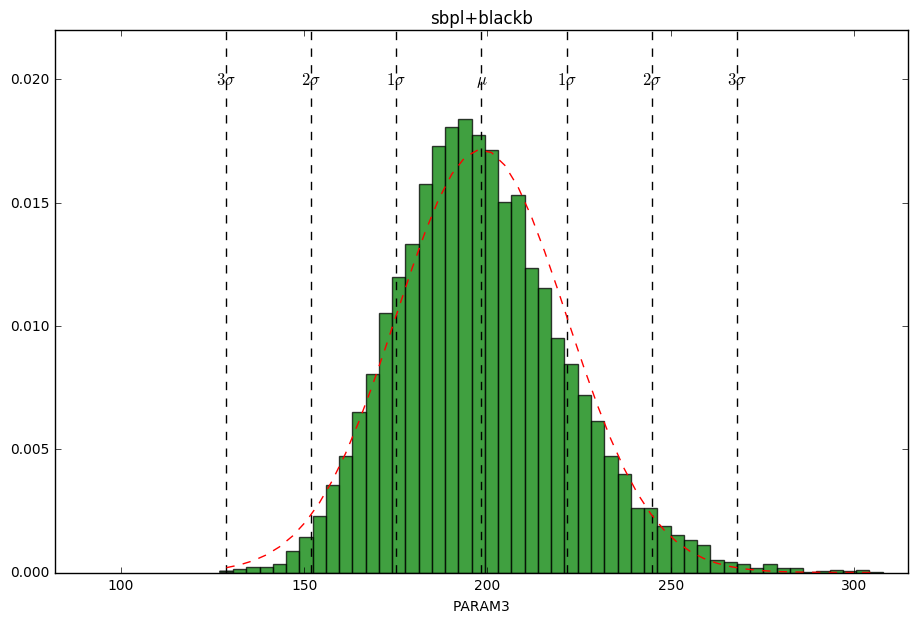

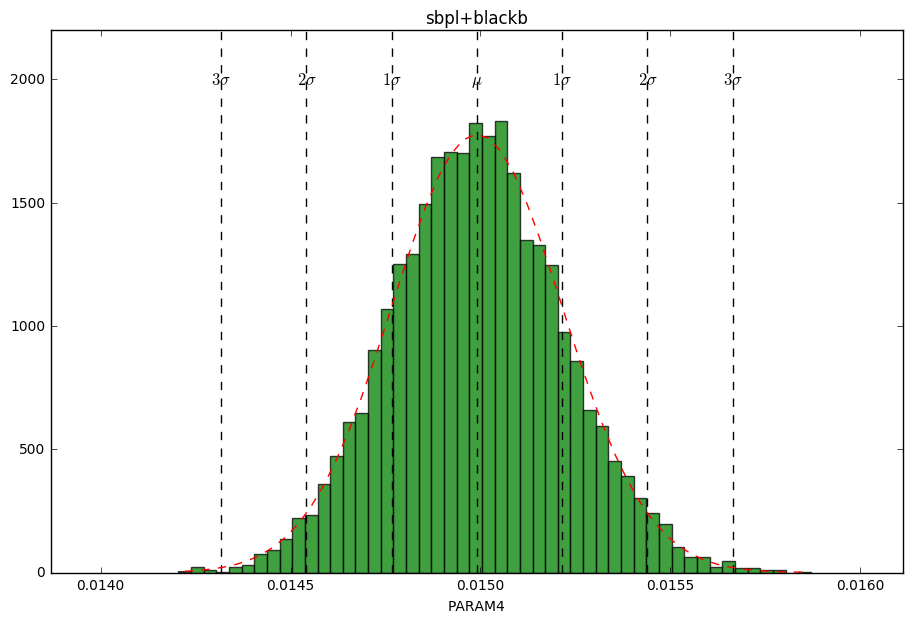

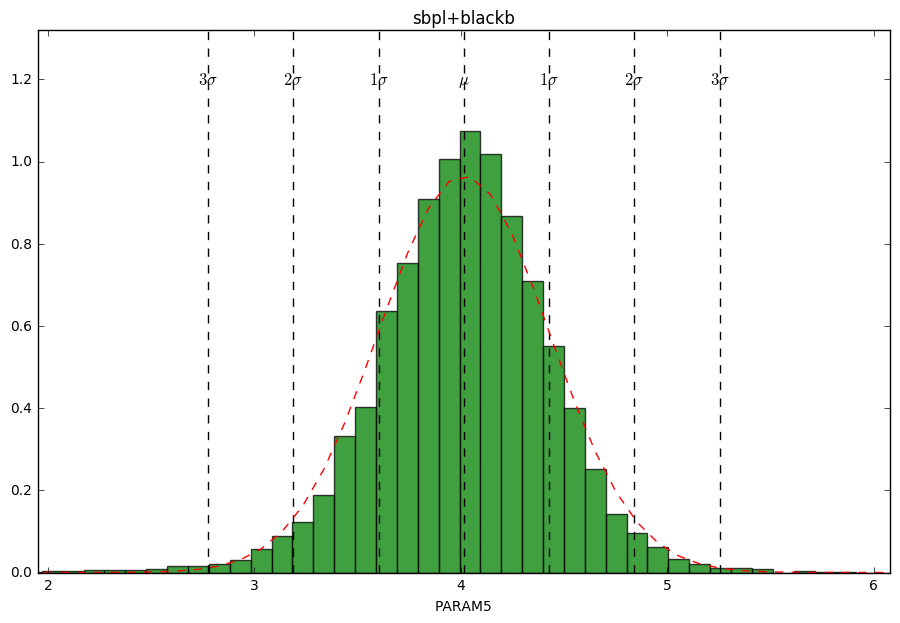

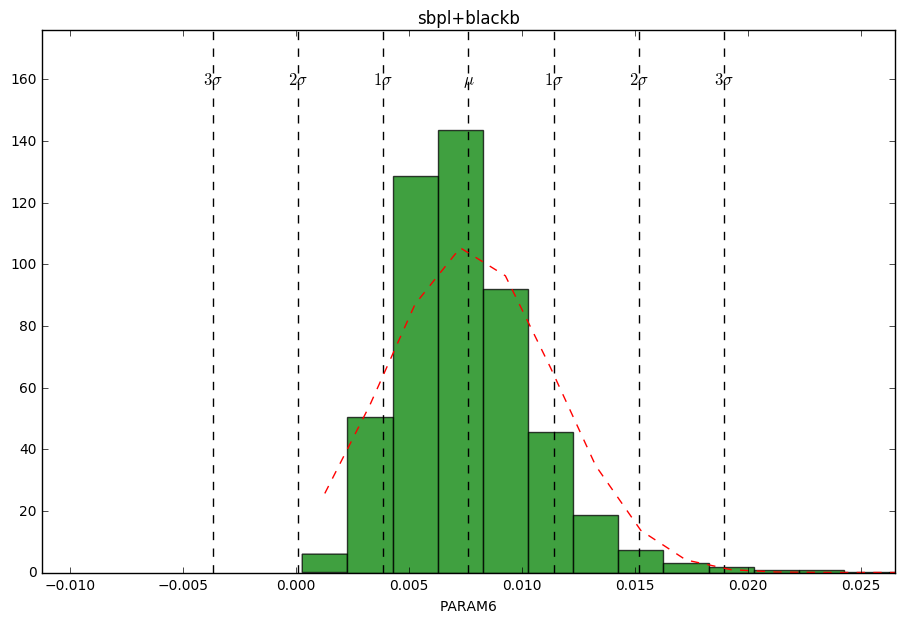

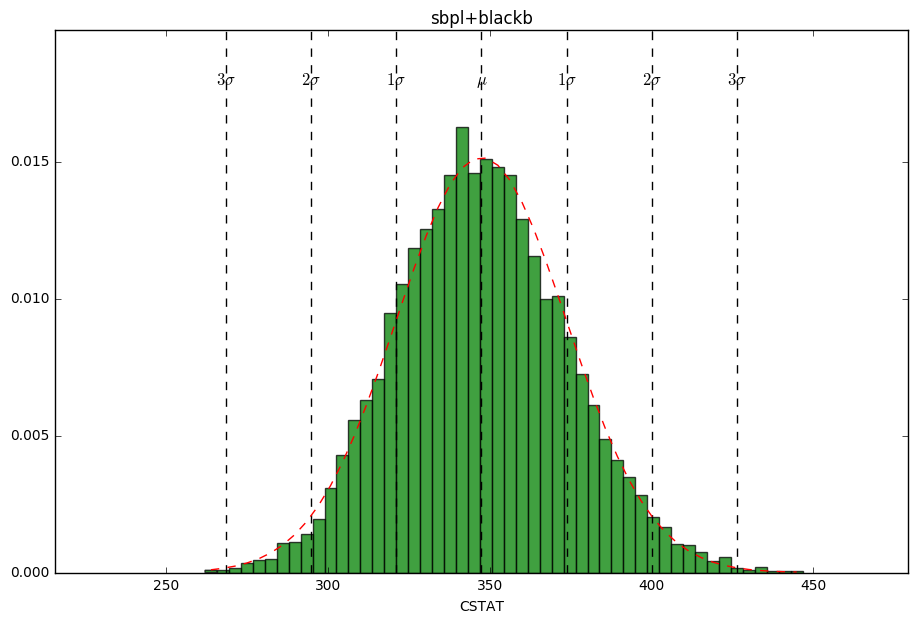

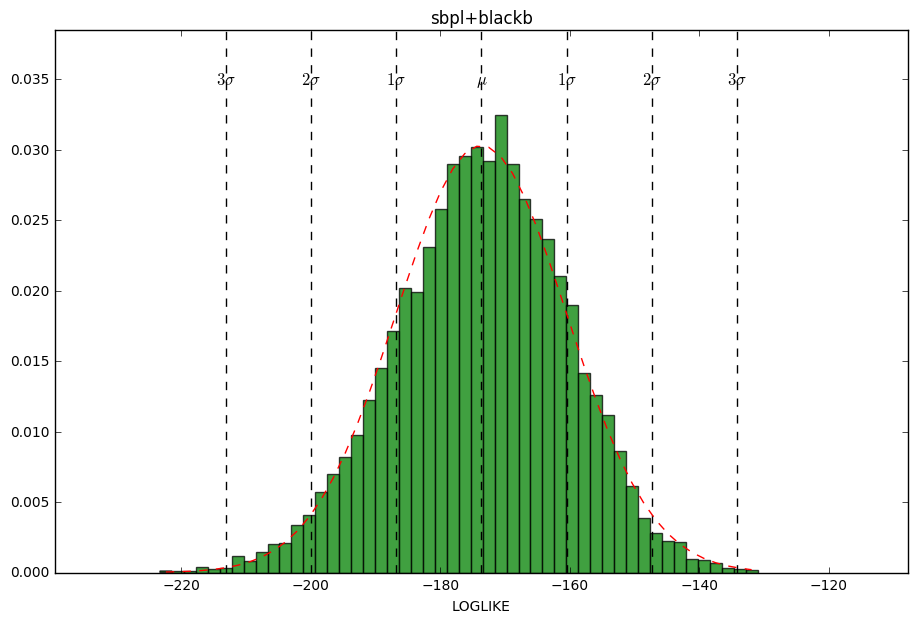

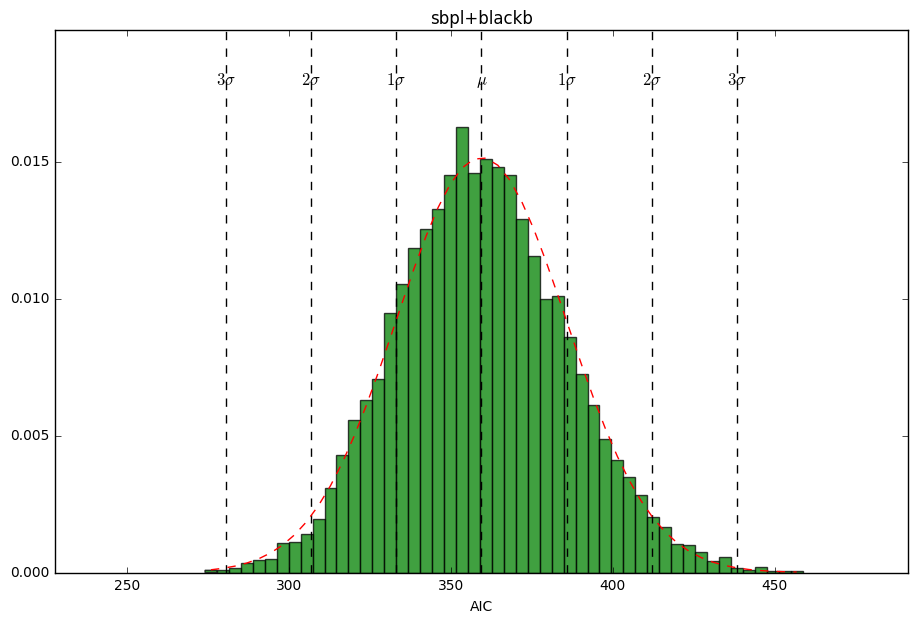

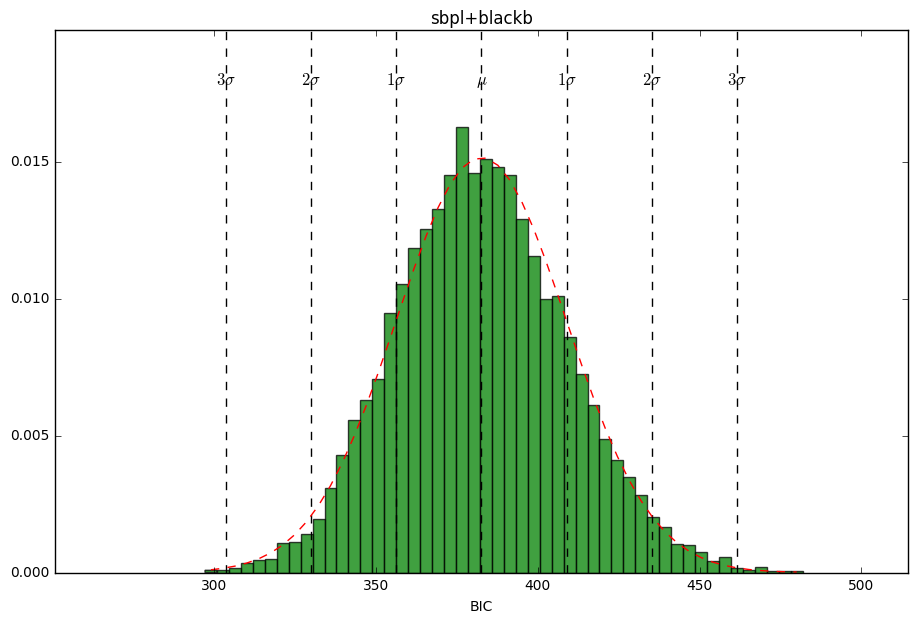

In [12]:
for name in FakeParams.columns:
    if 'PARAM' in name:
        Plot_ParamDistributions(modname, name)
        plt.savefig(pp, format='pdf', dpi=150, bbox_inches = 'tight')
    elif ('AIC' in name) or ('BIC' in name) or ('LOGLIKE' in name) or ('CSTAT' in name):
        Plot_ParamDistributions(modname, name)
        plt.savefig(pp, format='pdf', dpi=150, bbox_inches = 'tight')
    else:
        pass

In [13]:
pp.close()

In [14]:
target = open(paramoutfile2, 'w')

In [15]:
for name in FakeParams.columns:
    if 'PARAM' in name:
        x = FakeParams["%s"%name]
        muX, sigmaX = np.mean(x), np.sqrt(np.var(x))
        line1 =  "%s"%name
        line2 = "Value:    %.13f"%muX
        line3 = "1-sigma:  %.13f, %.13f"%(muX - sigmaX, muX + sigmaX)
        line4 = "2-sigma:  %.13f, %.13f"%(muX - 2*sigmaX, muX + 2*sigmaX)
        line5 = "3-sigma:  %.13f, %.13f"%(muX - 3*sigmaX, muX + 3*sigmaX)
        line6 = "min max:  %.13f, %.13f"%(x.min(), x.max())
        #print ""
        target.write(line1)
        target.write("\n")
        target.write(line2)
        target.write("\n")
        target.write(line3)
        target.write("\n")
        target.write(line4)
        target.write("\n")
        target.write(line5)
        target.write("\n")
        target.write(line6)
        target.write("\n")
        target.write("\n")
    elif ('AIC' in name) or ('BIC' in name) or ('LOGLIKE' in name) or ('CSTAT' in name):
        x = FakeParams["%s"%name]
        muX, sigmaX = np.mean(x), np.sqrt(np.var(x))
        line1 =  "%s"%name
        line2 = "Value:    %.13f"%muX
        line3 = "1-sigma:  %.13f, %.13f"%(muX - sigmaX, muX + sigmaX)
        line4 = "2-sigma:  %.13f, %.13f"%(muX - 2*sigmaX, muX + 2*sigmaX)
        line5 = "3-sigma:  %.13f, %.13f"%(muX - 3*sigmaX, muX + 3*sigmaX)
        line6 = "min max:  %.13f, %.13f"%(x.min(), x.max())
        #print ""
        target.write(line1)
        target.write("\n")
        target.write(line2)
        target.write("\n")
        target.write(line3)
        target.write("\n")
        target.write(line4)
        target.write("\n")
        target.write(line5)
        target.write("\n")
        target.write(line6)
        target.write("\n")
        target.write("\n")
    else:
        pass

In [16]:
target.close()

In [17]:
param_dict = OrderedDict()
for name in FakeParams.columns:
    if 'PARAM' in name:
        x = FakeParams["%s"%name]
        muX, sigmaX = np.mean(x), np.sqrt(np.var(x))
        # print "%s"%name
        # print "Value:    %.13f"%muX
        # print "1-sigma:  %.13f, %.13f"%(muX - sigmaX, muX + sigmaX)
        # print "2-sigma:  %.10f, %.10f"%(muX - 2*sigmaX, muX + 2*sigmaX)
        # print "3-sigma:  %.10f, %.10f"%(muX - 3*sigmaX, muX + 3*sigmaX)
        # print ""
        param_dict["%s"%name] = [muX, muX - sigmaX, muX + sigmaX, muX - 2*sigmaX, muX + 2*sigmaX, muX - 3*sigmaX, muX + 3*sigmaX, x.min(), x.max()]
    elif ('AIC' in name) or ('BIC' in name) or ('LOGLIKE' in name) or ('CSTAT' in name):
        x = FakeParams["%s"%name]
        muX, sigmaX = np.mean(x), np.sqrt(np.var(x))
        param_dict["%s"%name] = [muX, muX - sigmaX, muX + sigmaX, muX - 2*sigmaX, muX + 2*sigmaX, muX - 3*sigmaX, muX + 3*sigmaX, x.min(), x.max()]
    else:
        pass
        

In [18]:
outDataFrame = pd.DataFrame(param_dict)

In [19]:
outDataFrame.to_csv(path_or_buf = paramoutfile1, sep = ',', header=True, index=False)

In [20]:
os.system('cp %s %s'%(outfile1, outfile2))

0